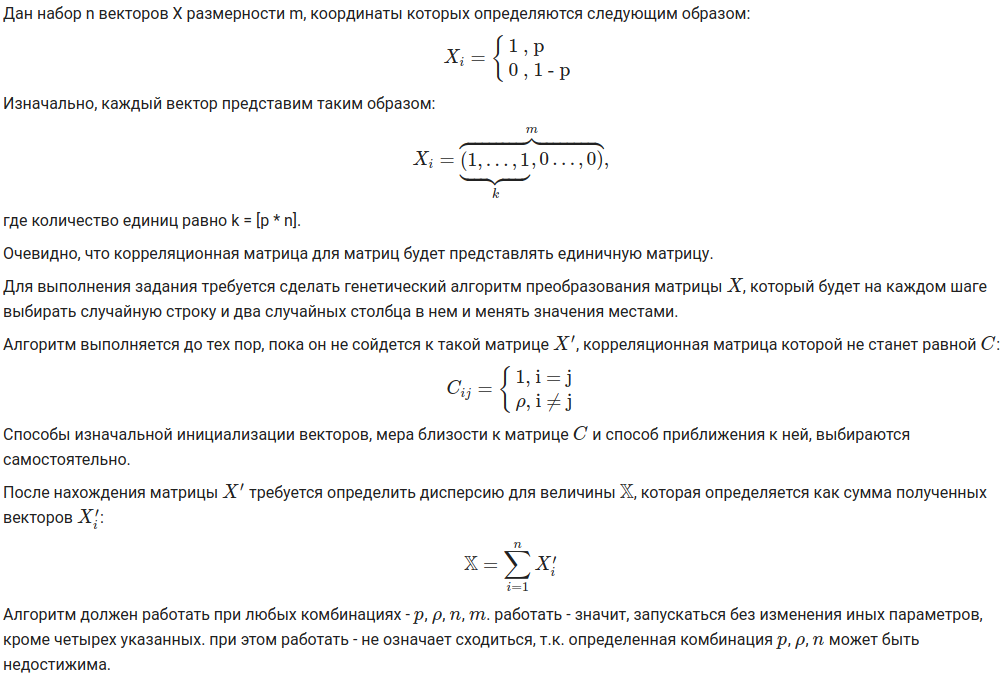

In [1]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#p, R, n, m = float(input()), float(input()), int(input()), int(input())
p, R, n, m = 0.04, 0.01, 100, 200
k = int(p * m)
target_corr_matrix = np.array([[R] * n] * n)
np.fill_diagonal(target_corr_matrix, 1)

Реализация без проверки оптимальности свопа (на больших данных может быть очень долгая сходимость)

In [3]:
X = np.array([[1] * k + [0] * (m - k)] * n).T
V = np.var(X[:, 0]) # Дисперсия столбца (постоянная для любого столбца в любой момент времени)

j = 0
corr_matrix = np.corrcoef(X, rowvar = False)
eps = np.mean(corr_matrix - target_corr_matrix)

while np.abs(eps) > 0.0001:
  j = (j + 1) % n
  i_1, i_2 = randint(0, m - 1), randint(0, m - 1)
  while X[i_1][j] == X[i_2][j]:
    i_2 = randint(0, m - 1)
  X[i_1][j], X[i_2][j] = X[i_2][j], X[i_1][j]

  # Данные 3 строчки позволяют быстрее считать corr_matrix
  cor = (X[:, j].T - p).dot(X[:, :] - p) / (m * V)
  corr_matrix[:, j] = cor
  corr_matrix[j, :] = cor
  
  eps = np.mean(corr_matrix - target_corr_matrix)

first_realize = np.sum(X, axis = 1)

Реализация с проверкой оптимальности свопа

In [4]:
X = np.array([[1] * k + [0] * (m - k)] * n).T
V = np.var(X[:, 0])

iter_count = 0
corr_matrix = np.corrcoef(X, rowvar = False)
eps = np.mean(corr_matrix - target_corr_matrix)

while np.abs(eps) > 0.0001 and iter_count < 10000:
  iter_count += 1
  j = iter_count % n
  i_1, i_2 = randint(0, m - 1), randint(0, m - 1)
  while X[i_1][j] == X[i_2][j]:
    i_2 = randint(0, m - 1)
  X[i_1][j], X[i_2][j] = X[i_2][j], X[i_1][j]

  old_corr_matrix = corr_matrix
  cor = (X[:, j].T - p).dot(X[:, :] - p) / (m * V)
  corr_matrix[:, j] = cor
  corr_matrix[j, :] = cor

  if np.abs(np.mean(corr_matrix - target_corr_matrix)) > eps: # Откат текущего шага
    X[i_1][j], X[i_2][j] = X[i_2][j], X[i_1][j]
    corr_matrix = old_corr_matrix
  else:
    eps = np.mean(corr_matrix - target_corr_matrix)

second_realize = np.sum(X, axis = 1)

Проверка правильности подсчета

In [5]:
print('Experimental var (first realize): ', np.var(first_realize))
print('Experimental var (second realize): ', np.var(second_realize))
print('Theoretical var: ', n * p * (1 - p) * (1 + (n - 1) * R))

Experimental var (first realize):  7.65
Experimental var (second realize):  7.48
Theoretical var:  7.6415999999999995


Гистограмма для первой реализации

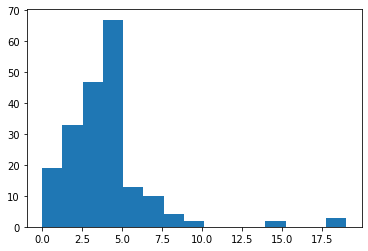

In [6]:
plt.hist(first_realize, bins = 15)
plt.show()

Гистограмма для второй реализации

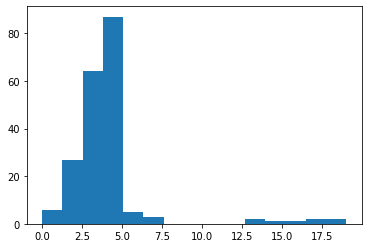

In [7]:
plt.hist(second_realize, bins = 15)
plt.show()

На некоторых входных данных вторая реализация создает некорректное распределение, в котором все значения находятся либо в районе нуля, либо в районе какой-то правой границы

Скорее всего необходимо как-то модифицировать этот метод. Была идея прогонять все "батчами", но значимого результата это не дало

P.S. В качестве расстояния выбрано просто среднее разностей, т.к. это дало большее качество, чем np.linalg, mae, mse